In [1]:
import torch
import numpy as np
import clip
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
image = preprocess(Image.open("CLIP/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004185 0.002968]]


In [4]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [5]:
import meerkat as mk
import glob
from torchvision.transforms import CenterCrop

In [39]:
all_images = []
labels = []
for path in glob.glob('/home/common/datasets/metadataset/proc/*'):
    images = list(glob.glob(f'{path}/*/*'))
    all_images.extend(images)
    labels.extend([path.split("/")[-1]] * len(images))

categories = [path.split("/")[-2].split("(")[-1].replace(")", "") for path in all_images]

In [41]:
dp = mk.DataPanel({
    'image': mk.ImageColumn.from_filepaths(
        filepaths=all_images,
    ),
    'label': labels,
    'category': categories,
})
dp

,image (ImageColumn),label (ListColumn),category (ListColumn),index (ListColumn)
0,ImageCell(/home/common/datasets/metadataset/pr...,'cow','bull','0'
1,ImageCell(/home/common/datasets/metadataset/pr...,'cow','bull','1'
2,ImageCell(/home/common/datasets/metadataset/pr...,'cow','bull','2'
3,ImageCell(/home/common/datasets/metadataset/pr...,'cow','bull','3'
4,ImageCell(/home/common/datasets/metadataset/pr...,'cow','bull','4'
...,...,...,...,...
55614,ImageCell(/home/common/datasets/metadataset/pr...,'elephant','leaves','55614'
55615,ImageCell(/home/common/datasets/metadataset/pr...,'elephant','leaves','55615'
55616,ImageCell(/home/common/datasets/metadataset/pr...,'elephant','leaves','55616'
55617,ImageCell(/home/common/datasets/metadataset/pr...,'elephant','leaves','55617'


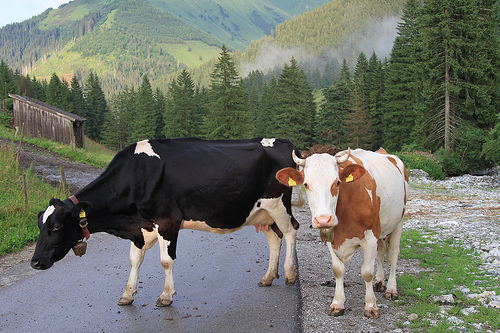

In [43]:
dp['image'][0]

In [11]:
import json
train_scenegraphs = json.load(open('/home/common/datasets/metadataset/train_sceneGraphs.json'))

In [52]:
%%time
for x in dp.lz['image'].lz:
    pass

CPU times: user 528 ms, sys: 0 ns, total: 528 ms
Wall time: 527 ms


In [44]:
# Add the ID column
dp['id'] = dp.map(lambda x: x['image'].data.split("/")[-1].strip(".jpg"), materialize=False)

In [13]:
def fetch_scenegraph(x):
    try:
        return train_scenegraphs[x]
    except:
        return {}
dp['scenegraph'] = mk.LambdaColumn(dp['id'], fetch_scenegraph)

In [20]:
from copy import deepcopy

def simplify_scenegraph(scenegraph):
    object_to_name_mapping = {}
    for obj_id, obj_info in scenegraph['objects'].items():
        object_to_name_mapping[obj_id] = obj_info['name']
    objects = {}
    for obj_id, obj_info in scenegraph['objects'].items():
        objects[obj_info['name']] = deepcopy(obj_info)
        objects[obj_info['name']]['relations'] = []
        for relation in obj_info['relations']:
            objects[obj_info['name']]['relations'].append((relation['name'], object_to_name_mapping[relation['object']]))
        
    return objects
    

def fetch_category_info(x):
    for obj_id, obj_info in x['scenegraph']['objects'].items():
        if obj_info['name'] == x['category']:
            return obj_info
    return {}

dp['objects'] = mk.LambdaColumn(dp['scenegraph'], simplify_scenegraph)

In [26]:
%%time
dp['objects'][0]

CPU times: user 285 µs, sys: 0 ns, total: 285 µs
Wall time: 288 µs


{'coffee': {'name': 'coffee',
  'h': 17,
  'relations': [('inside', 'cup'),
   ('to the left of', 'napkin'),
   ('to the left of', 'remote control'),
   ('to the left of', 'fries')],
  'w': 75,
  'attributes': [],
  'y': 261,
  'x': 50},
 'nose': {'name': 'nose',
  'h': 36,
  'relations': [('to the right of', 'remote control')],
  'w': 40,
  'attributes': [],
  'y': 295,
  'x': 430},
 'dog': {'name': 'dog',
  'h': 292,
  'relations': [],
  'w': 481,
  'attributes': [],
  'y': 40,
  'x': 0},
 'napkin': {'name': 'napkin',
  'h': 66,
  'relations': [('near', 'cup'),
   ('to the right of', 'cup'),
   ('to the left of', 'fries'),
   ('to the left of', 'remote control'),
   ('next to', 'cup'),
   ('to the right of', 'coffee')],
  'w': 91,
  'attributes': ['white'],
  'y': 266,
  'x': 120},
 'table': {'name': 'table',
  'h': 101,
  'relations': [],
  'w': 499,
  'attributes': [],
  'y': 231,
  'x': 0},
 'fries': {'name': 'fries',
  'h': 275,
  'relations': [('to the right of', 'napkin'),
   (

In [ ]:
%%time
dp['objects'][0]

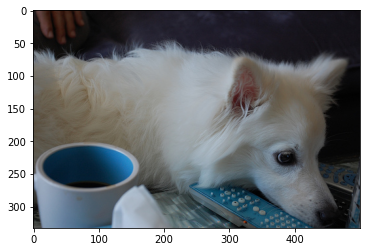

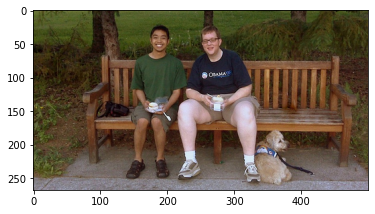

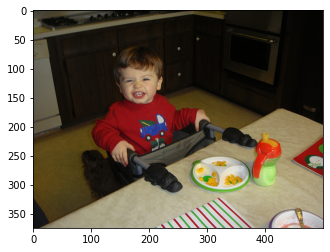

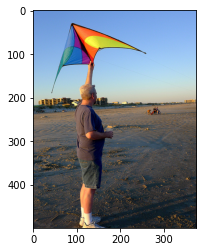

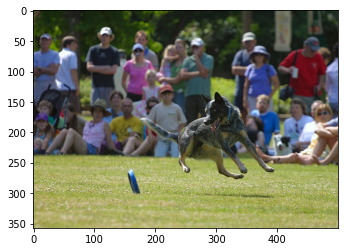

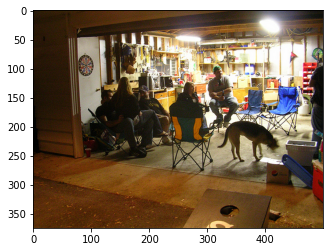

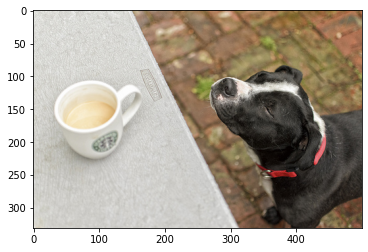

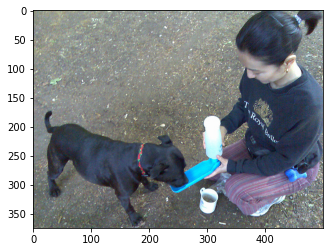

In [40]:
train_scenegraphslotlib.pyplot as plt
for im in dp['image'][:8]:
    plt.imshow(im)
    plt.show()

This seems to run far too slowly.

In [23]:
%%time
dp = dp.update(
    lambda x: {'category': x['image'].data.split("/")[-2].split("(")[-1].replace(")", "")},
    materialize=False,
    input_columns=['image'],
)
dp

CPU times: user 8.11 s, sys: 0 ns, total: 8.11 s
Wall time: 8.1 s


,image (ImageColumn),label (ListColumn),index (ListColumn),id (ListColumn),scenegraph (LambdaColumn),objects (LambdaColumn),category (ListColumn)
0,ImageCell(/home/common/datasets/metadataset/pr...,'dog','0','2355964',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'cup'
1,ImageCell(/home/common/datasets/metadataset/pr...,'dog','1','2363267',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'cup'
2,ImageCell(/home/common/datasets/metadataset/pr...,'dog','2','2408746',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'cup'
3,ImageCell(/home/common/datasets/metadataset/pr...,'dog','3','2366946',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'cup'
4,ImageCell(/home/common/datasets/metadataset/pr...,'dog','4','2382399',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'cup'
...,...,...,...,...,...,...,...
18146,ImageCell(/home/common/datasets/metadataset/pr...,'cat','18146','2403962',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'bird'
18147,ImageCell(/home/common/datasets/metadataset/pr...,'cat','18147','2386073',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'bird'
18148,ImageCell(/home/common/datasets/metadataset/pr...,'cat','18148','2345383',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'bird'
18149,ImageCell(/home/common/datasets/metadataset/pr...,'cat','18149','2356198',LambdaCell(fn=fetch_scenegraph),LambdaCell(fn=simplify_scenegraph),'bird'


In [41]:
image = preprocess(dp['image'][200]).unsqueeze(0).to(device)
text = clip.tokenize(["medical", "dog", "cat", "cup", "kid", "pillow", "a sleeping dog", 
                      "a dog sleeping on a bed", "a bed with two pillows"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[1.2040e-05 9.8419e-04 5.9128e-05 1.3590e-05 4.6790e-05 1.2646e-03
  5.0507e-02 8.2764e-01 1.1926e-01]]


In [24]:
def preprocessor(x):
    return preprocess(x['image'])

def embed(image_batch):
    # This works
    with torch.no_grad():
        return model.encode_image(image_batch.data.to(device)).cpu()
    
def _embed(image_batch):
    # This doesn't work
    with torch.no_grad():
        return model.encode_image(image_batch.to(device)).cpu()

In [25]:
plt.imshow(preprocessor(dp[0]).numpy().transpose(1,2,0))

NameError: name 'plt' is not defined

In [213]:
dp.map?

In [44]:
sdp = dp.lz[list(range(100))]

In [48]:
sdp['image:preprocessor'] = sdp.map(preprocessor, input_columns=['image'])

In [49]:
sdp

,image (ImageColumn),label (ListColumn),category (ListColumn),index (ListColumn),image:preprocessor (TensorColumn)
0,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','0',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
1,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','1',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
2,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','2',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
3,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','3',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
4,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','4',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
...,...,...,...,...,...
95,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','95',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
96,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','96',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
97,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','97',"torch.Tensor(shape=torch.Size([3, 224, 224]))"
98,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','98',"torch.Tensor(shape=torch.Size([3, 224, 224]))"


In [50]:
sdp['image:clip'] = sdp.map(lambda x: embed(x['image:preprocessor']), input_columns=['image:preprocessor'], is_batched_fn=True)

In [52]:
sdp

,image (ImageColumn),label (ListColumn),category (ListColumn),index (ListColumn),image:preprocessor (TensorColumn),image:clip (TensorColumn)
0,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','0',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
1,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','1',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
2,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','2',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
3,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','3',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
4,ImageCell(/home/common/datasets/metadataset/pr...,'dog','cup','4',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
...,...,...,...,...,...,...
95,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','95',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
96,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','96',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
97,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','97',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))
98,ImageCell(/home/common/datasets/metadataset/pr...,'dog','boy','98',"torch.Tensor(shape=torch.Size([3, 224, 224]))",torch.Tensor(shape=torch.Size([512]))


In [85]:
with torch.no_grad():
    text = clip.tokenize(["a dog", "a cup", "a boy"]).to(device)
    text_features = model.encode_text(text).cpu()
    text_features

In [ ]:
def forward(self, image, text):
    image_features = self.encode_image(image)
    text_features = self.encode_text(text)

    # normalized features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # cosine similarity as logits
    logit_scale = self.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logit_scale * text_features @ image_features.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text

In [88]:
logits_per_image, logits_per_text = model(sdp['image:preprocessor'].data.to(device), text)
logits_per_image

tensor([[24.8594, 25.3750, 21.9844],
        [22.6875, 24.2344, 20.2031],
        [17.6094, 20.0312, 22.1719],
        [20.1719, 19.7188, 20.8125],
        [22.5469, 16.8281, 18.3125],
        [21.6719, 19.2344, 17.9375],
        [23.4062, 24.7500, 18.7812],
        [24.0938, 25.0156, 21.3125],
        [18.5000, 17.0156, 17.6406],
        [19.2656, 20.4375, 18.0469],
        [21.9062, 20.3594, 18.2031],
        [22.2188, 19.7188, 16.6094],
        [25.1875, 21.5781, 22.5469],
        [17.2656, 23.7188, 16.5625],
        [20.6719, 17.7344, 17.0312],
        [22.6250, 20.2188, 18.0625],
        [24.5781, 19.3281, 21.2969],
        [24.0000, 19.6406, 20.6250],
        [23.5469, 21.6562, 19.9531],
        [24.8281, 18.8594, 19.6719],
        [21.8594, 20.2344, 18.4531],
        [22.8594, 17.3281, 17.4688],
        [24.8438, 24.0312, 21.3594],
        [17.7656, 18.5312, 17.0625],
        [17.9531, 19.9688, 17.4844],
        [22.2500, 17.7344, 18.2344],
        [18.5469, 20.2188, 20.7188],
 

In [98]:
sdp.lz[np.argsort(logits_per_image[:, 2].cpu().detach().numpy())]['category']

,(ListColumn)
0,'boy'
1,'boy'
2,'boy'
3,'boy'
4,'boy'
...,...
95,'boy'
96,'boy'
97,'boy'
98,'boy'


In [184]:
import numpy as np
np.dot(image_features.cpu(), text_features.cpu().T)

array([[27.22, 30.38, 25.77, 24.23, 29.31, 27.5 , 30.88, 29.92]],
      dtype=float16)

In [24]:
from meerkat.contrib.wilds import get_wilds_datapanel

In [25]:
dp = get_wilds_datapanel("fmow", root_dir="/home/common/datasets", split="test")

In [26]:
dp['input'][0]

TypeError: _get_cell() got an unexpected keyword argument 'materialize'

In [ ]:
import numpy as np
dp['input'].data

In [6]:
from meerkat.contrib.mimic import build_mimic_dp
dp = build_mimic_dp(
    '/home/common/datasets/mimic/',
    gcp_project='hai-gcp-fine-grained',
)

In [23]:
preprocess(dp['img'][0]).unsqueeze(0).to(device)
text = clip.tokenize(["medical", "dog", "cat"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.1229 0.4863 0.3909]]


In [44]:
import numpy as np
arr = np.zeros((5000,10000))

In [45]:
%%time
_ = arr[:, 0]

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 16.2 µs


In [47]:
%%time
for i in range(5000):
    %time _ = arr[i, 0]

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 13.8 µs
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.11 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs
CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 7.63 µs
CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 6.68 µs
CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 6.91 µs
CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 7.63 µs
CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 7.15 µs
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 9.06 µs
CPU times: user 5 µs, sys: 1 µs, to